# Predictive Maintenace in Milling Machine 

### Importing required libraries 

In [1]:
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

/var/folders/6k/z_5jgpzx3gv7nz188p4vycxr0000gn/T/ipykernel_71154/3994724798.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

### Loading the dataset 

In [4]:
df = pd.read_csv('ai4i2020.csv')
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    0    0

# About the Dataset 
This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true. 

The machine failure consists of five independent failure modes

1. Tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. Heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. Power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. Overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. Random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset. 

## Analysis of Dataset 
It seems that there are two indices: the index and ProductID. We can drop those. There is a Type which is categorical and the remainder are numeric. The last five feastures are all failure modes, so they will not be evaluated in this notebook. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
df.shape

(10000, 14)

## Missing values  
so there are no missing values at all data is good to go 

In [7]:
df.describe(include='all').T 

# This generates descriptive statistics for all columns in the DataFrame df, regardless of data type (numeric, object, datetime, etc.).
# For numerical columns: it shows count, mean, std, min, 25%, 50%, 75%, and max.
# For categorical (object) columns: it shows count, unique, top (most frequent value), and freq (frequency of the top value).
# For datetime columns: it shows count, first, last, etc.
# .T to transpose the rows and columns of result for better and cleaner view 

count unique     top  freq       mean         std     min      25%     50%      75%      max
UDI                      10000.0    NaN     NaN   NaN     5000.5  2886.89568     1.0  2500.75  5000.5  7500.25  10000.0
Product ID                 10000  10000  M14860     1        NaN         NaN     NaN      NaN     NaN      NaN      NaN
Type                       10000      3       L  6000        NaN         NaN     NaN      NaN     NaN      NaN      NaN
Air temperature [K]      10000.0    NaN     NaN   NaN  300.00493    2.000259   295.3    298.3   300.1    301.5    304.5
Process temperature [K]  10000.0    NaN     NaN   NaN  310.00556    1.483734   305.7    308.8   310.1    311.1    313.8
Rotational speed [rpm]   10000.0    NaN     NaN   NaN  1538.7761  179.284096  1168.0   1423.0  1503.0   1612.0   2886.0
Torque [Nm]              10000.0    NaN     NaN   NaN   39.98691    9.968934     3.8     33.2    40.1     46.8     76.6
Tool wear [min]          10000.0    NaN     NaN   NaN    107.951   63.654147     0.0     53.0   108.0    162.0    253.0
Machine failure          10000.0    NaN     NaN   NaN     0.0339    0.180981     0.0      0.0     0.0      0.0      1.0
TWF                      10000.0    NaN     NaN   NaN     0.0046    0.067671     0.0      0.0     0.0      0.0      1.0
HDF                      10000.0    NaN     NaN   NaN     0.0115    0.106625     0.0      0.0     0.0      0.0      1.0
PWF                      10000.0    NaN     NaN   NaN     0.0095    0.097009     0.0      0.0     0.0      0.0      1.0
OSF                      10000.0    NaN     NaN   NaN     0.0098    0.098514     0.0      0.0     0.0      0.0      1.0
RNF                      10000.0    NaN     NaN   NaN     0.0019     0.04355     0.0      0.0     0.0      0.0      1.0

### Turning all columns into float for easier processing 

In [8]:
for column in df.columns:
    try:
        df[column]=df[column].astype(float)
    except:
        pass

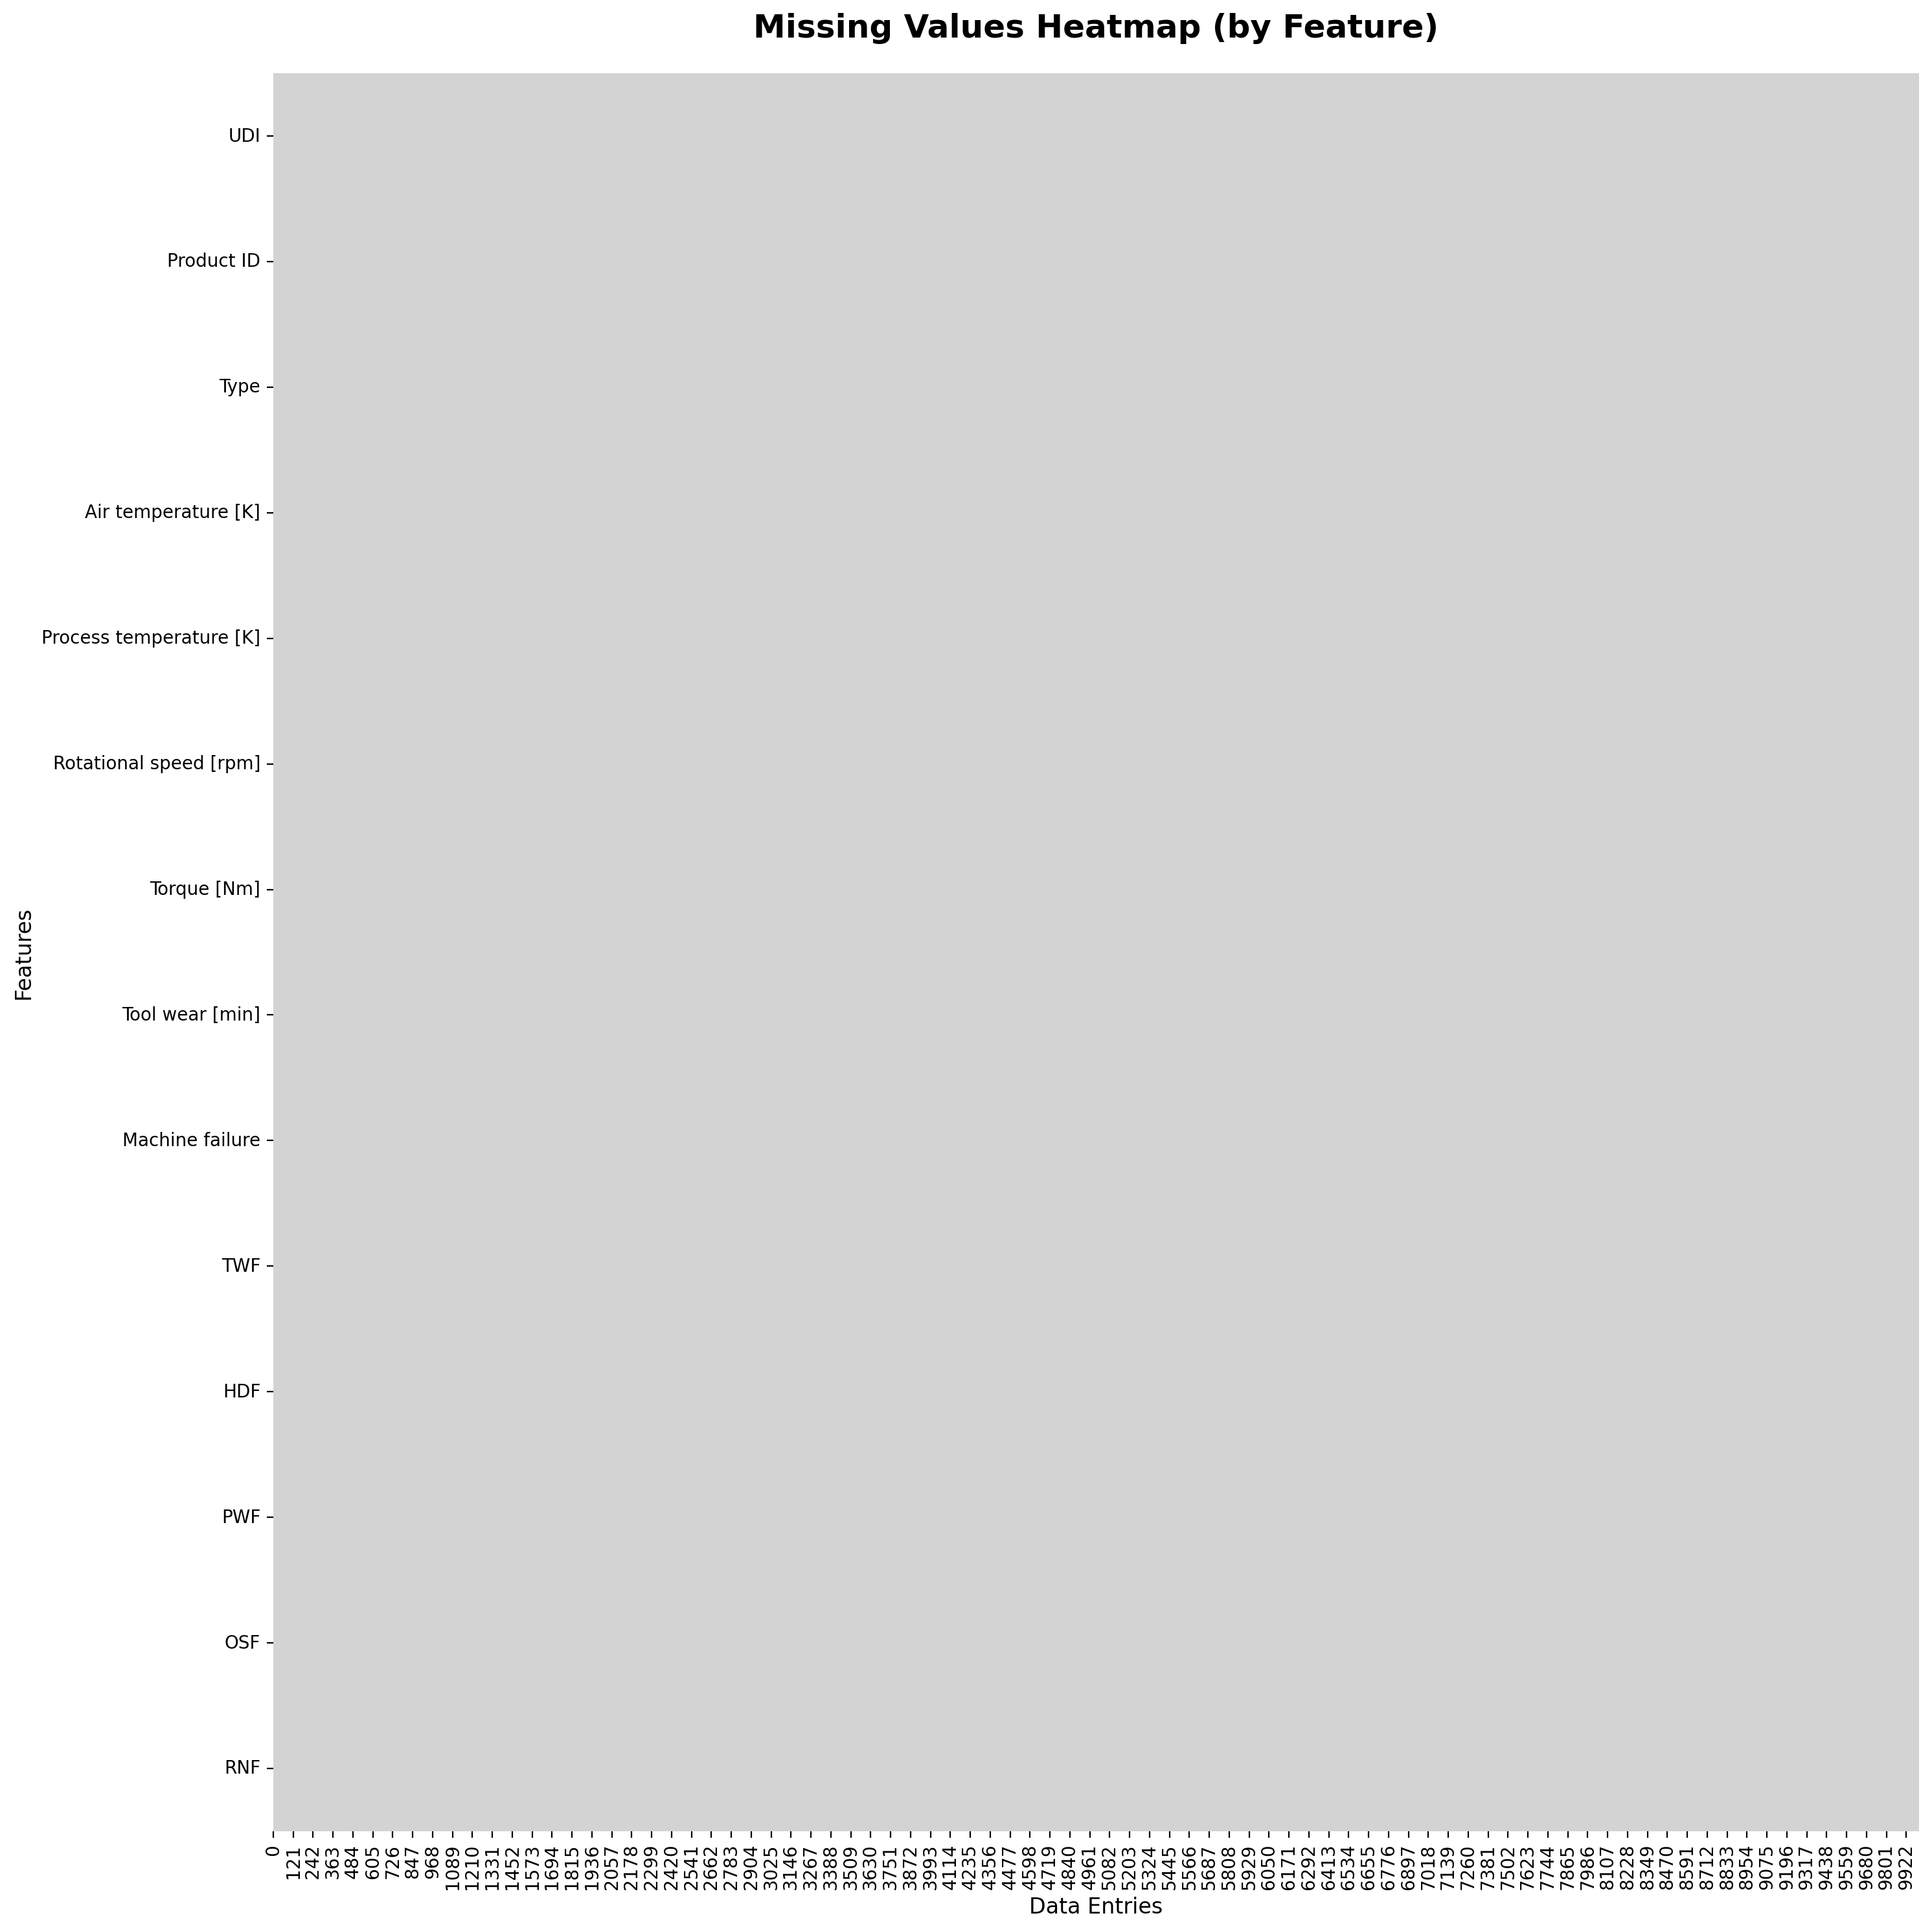

In [9]:
plt.figure(figsize=(15, 15))

sns.heatmap(
    df.isna().transpose(),
    cmap='cividis',
    cbar=False,            # Hides the color bar for cleaner look
    linewidths=0.5,
    linecolor='lightgray'  # Optional: grid lines between cells
).set_facecolor('white')

plt.title("Missing Values Heatmap (by Feature)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Data Entries", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()

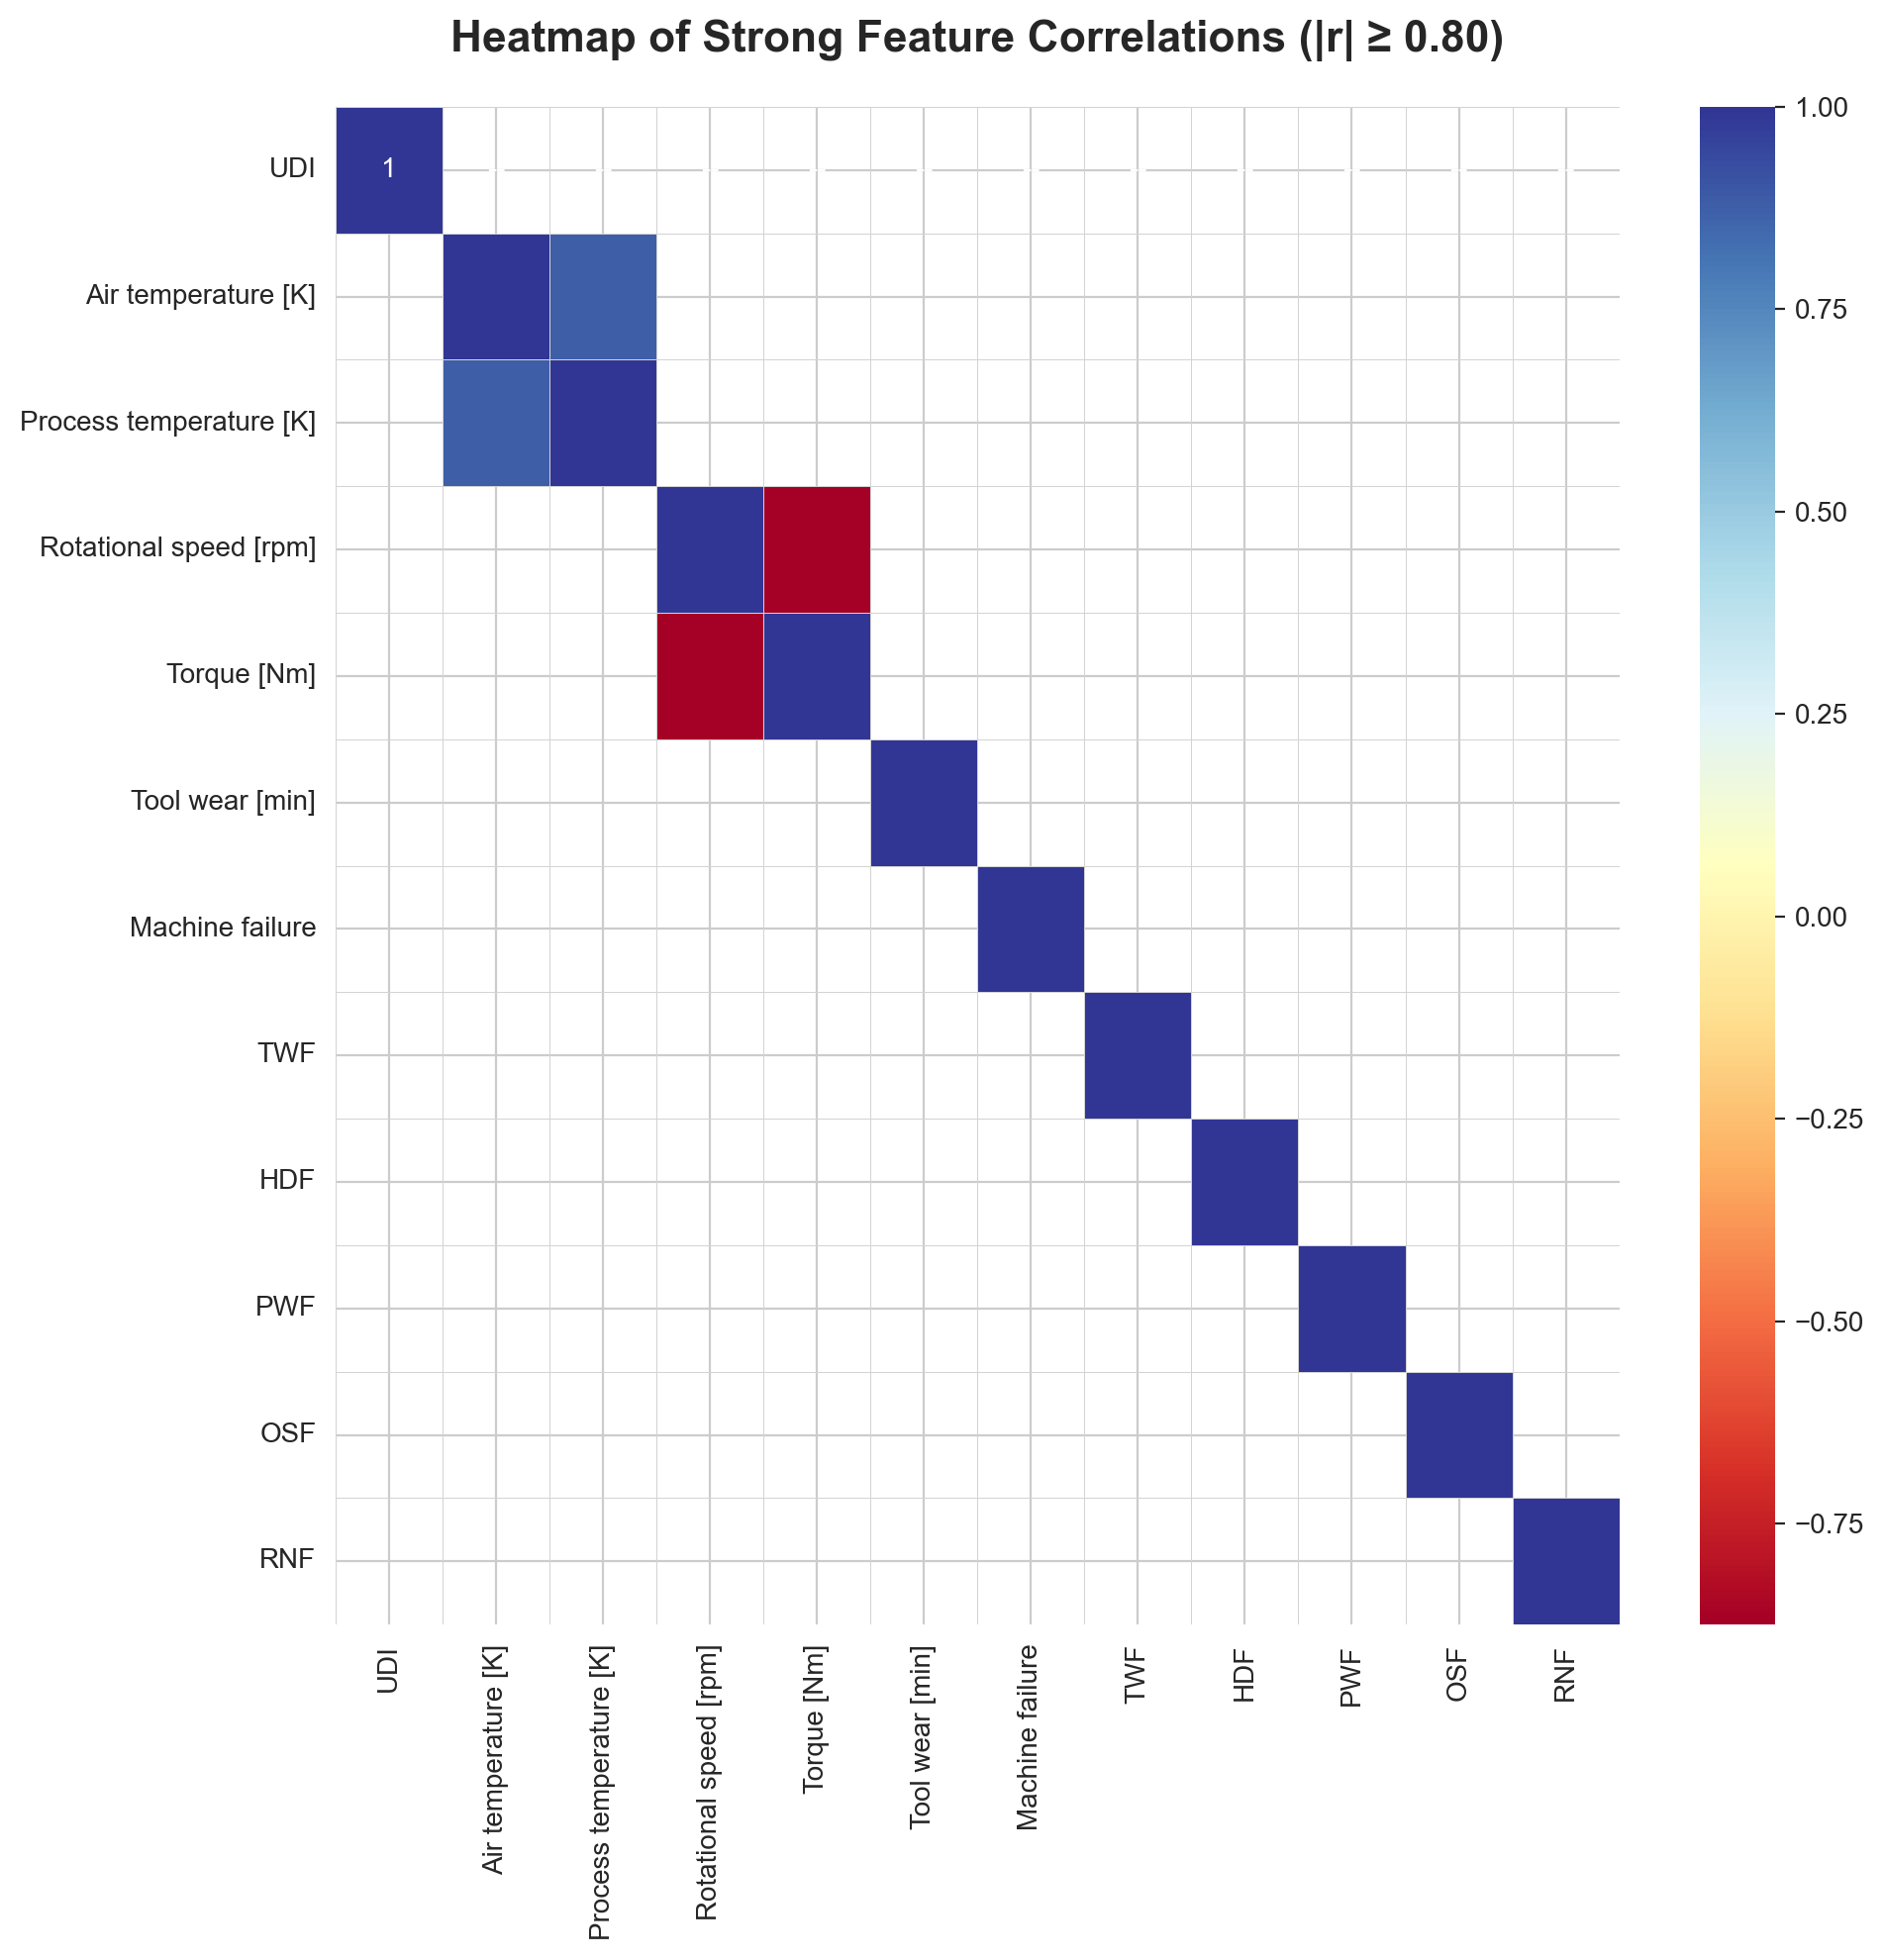

In [10]:
# Select only numeric columns for correlation
df_numeric = df.select_dtypes(include='number')

plt.figure(figsize=(10,10))
threshold = 0.80
sns.set_style("whitegrid", {"axes.facecolor": ".0"})

# Compute correlation only on numeric data
df_cluster2 = df_numeric.corr()

# Mask weak correlations
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()

# Plot the heatmap
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

plt.title("Heatmap of Strong Feature Correlations (|r| ≥ 0.80)", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [11]:
df_numeric.corr()

UDI  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure       TWF       HDF       PWF       OSF       RNF
UDI                      1.000000             0.117428                 0.324428               -0.006615     0.003207        -0.010702        -0.022892  0.009154 -0.022215 -0.023557 -0.000990 -0.005954
Air temperature [K]      0.117428             1.000000                 0.876107                0.022670    -0.013778         0.013853         0.082556  0.009955  0.137831  0.003470  0.001988  0.017688
Process temperature [K]  0.324428             0.876107                 1.000000                0.019277    -0.014061         0.013488         0.035946  0.007315  0.056933 -0.003355  0.004554  0.022279
Rotational speed [rpm]  -0.006615             0.022670                 0.019277                1.000000    -0.875027         0.000223        -0.044188  0.010389 -0.121241  0.123018 -0.104575 -0.013088
Torque [Nm]              0.003207            -0.013778                -0.014061               -0.875027     1.000000        -0.003093         0.191321 -0.014662  0.142610  0.083781  0.183465  0.016136
Tool wear [min]         -0.010702             0.013853                 0.013488                0.000223    -0.003093         1.000000         0.105448  0.115792 -0.001287 -0.009334  0.155894  0.011326
Machine failure         -0.022892             0.082556                 0.035946               -0.044188     0.191321         0.105448         1.000000  0.362904  0.575800  0.522812  0.531083  0.004516
TWF                      0.009154             0.009955                 0.007315                0.010389    -0.014662         0.115792         0.362904  1.000000 -0.007332  0.008577  0.038243  0.030970
HDF                     -0.022215             0.137831                 0.056933               -0.121241     0.142610        -0.001287         0.575800 -0.007332  1.000000  0.018443  0.046396 -0.004706
PWF                     -0.023557             0.003470                -0.003355                0.123018     0.083781        -0.009334         0.522812  0.008577  0.018443  1.000000  0.115836 -0.004273
OSF                     -0.000990             0.001988                 0.004554               -0.104575     0.183465         0.155894         0.531083  0.038243  0.046396  0.115836  1.000000 -0.004341
RNF                     -0.005954             0.017688                 0.022279               -0.013088     0.016136         0.011326         0.004516  0.030970 -0.004706 -0.004273 -0.004341  1.000000

## Profile Report 
### The profiling report follows to look for outliers, missing values, and distributions. We can see that the data is imbalanced. 

In [12]:
from ydata_profiling import ProfileReport

In [13]:
%%time
profile = ProfileReport(df,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for MOOC Project",
                                 "copyright_holder": "Anamika Saroha",
                                 "copyright_year": "2025",
                                },
                        explorative=True,

                       )
# To display the report in a notebook:
profile

# Alternatively to save as HTML:
# profile.to_file("predictive_maintenance_report.html")

CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 208 ms


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 129.21it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Dropping the indices as these have no predictive power 

In [14]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)

### Dropping the failure modes, as we're only interested whether something is a failure. 

In [15]:
df.drop(['TWF','HDF','PWF','OSF','RNF'],axis=1,inplace=True)

### Dropping the type, as this dominates too strongly on type = L. 

In [16]:
df.drop(['Type'],axis=1,inplace=True)

## Remaining Features 

In [17]:
list(df)

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure']

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   Machine failure          10000 non-null  float64
dtypes: float64(6)
memory usage: 468.9 KB


In [19]:
# final check for null values 

In [20]:
features = list(df.columns)
for feature in features:
    print(feature + " - " + str(len(df[df[feature].isna()])))

Air temperature [K] - 0
Process temperature [K] - 0
Rotational speed [rpm] - 0
Torque [Nm] - 0
Tool wear [min] - 0
Machine failure - 0


In [21]:
df_group = df.groupby(['Machine failure'])
df_group.count()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]
Machine failure                                                                                                    
0.0                             9661                     9661                    9661         9661             9661
1.0                              339                      339                     339          339              339

In [22]:
df[df['Machine failure'].isna()]

Empty DataFrame
Columns: [Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Machine failure]
Index: []

# Feature Selection 

In [23]:
df.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure
0                298.1                    308.6                  1551.0         42.8              0.0              0.0
1                298.2                    308.7                  1408.0         46.3              3.0              0.0
2                298.1                    308.5                  1498.0         49.4              5.0              0.0
3                298.2                    308.6                  1433.0         39.5              7.0              0.0
4                298.2                    308.7                  1408.0         40.0              9.0              0.0

# Step-1 Preparing Data 

In [24]:
from sklearn.model_selection import train_test_split

# Define feature set and target
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

# Train-test split (optional but good practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step-2 Feature Importance with Random Forest 

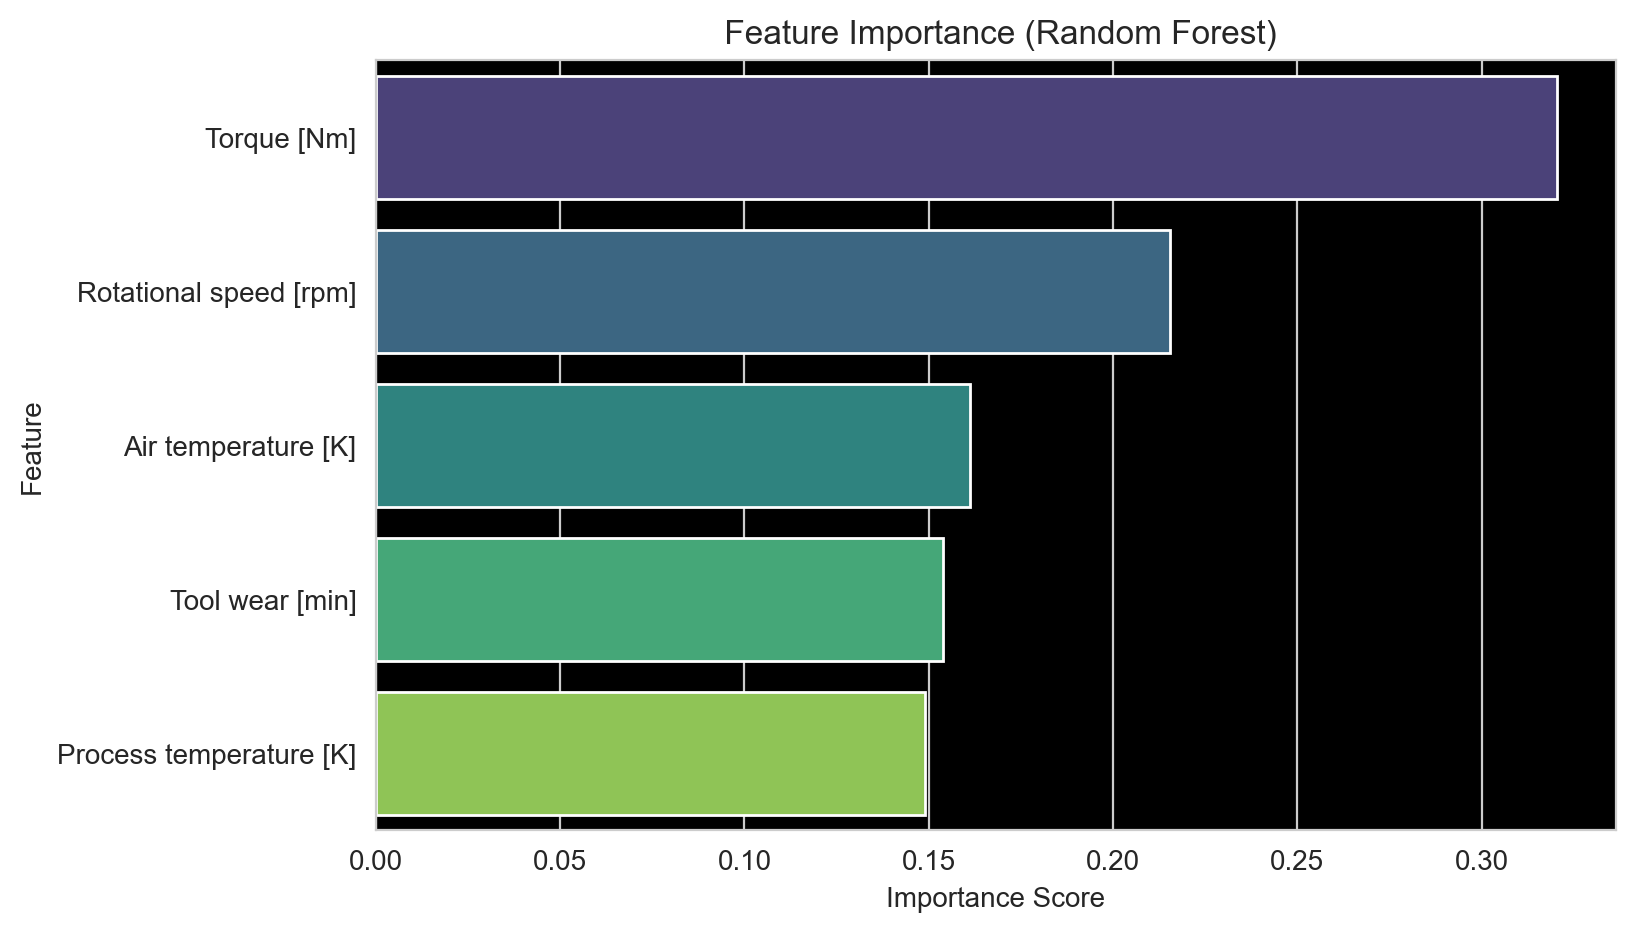

In [25]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(" Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Step 3: Feature Selection with SelectKBest 

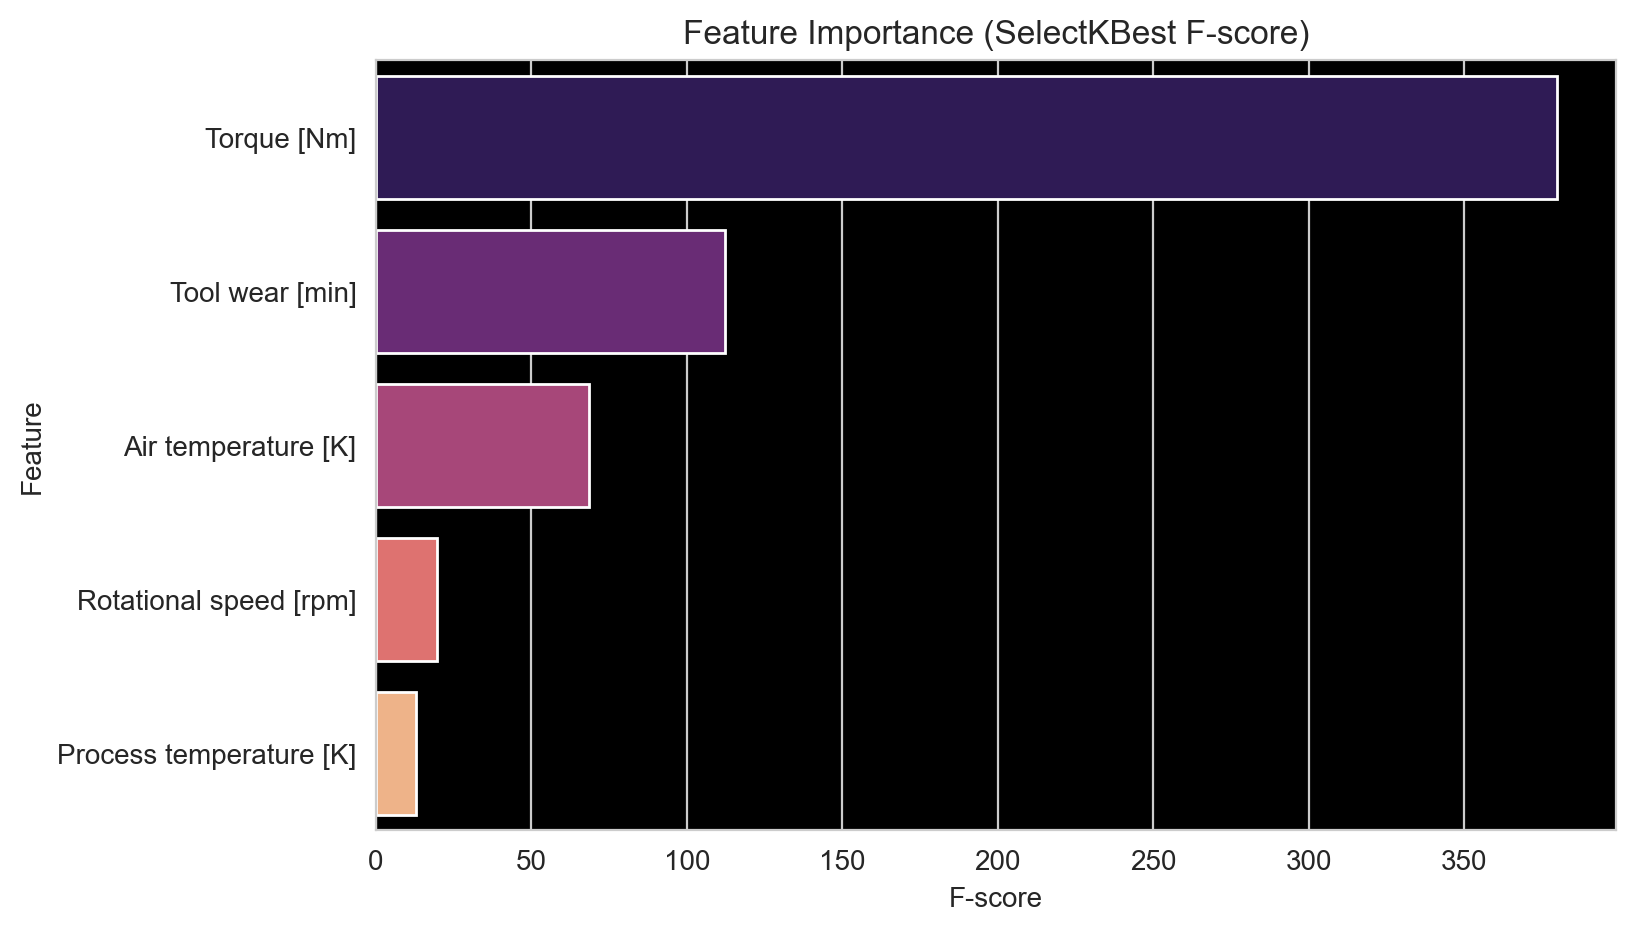

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Apply SelectKBest
k = 'all'  # or choose number like 3, 4 etc.
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

# Get scores
scores = selector.scores_
selectkbest_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': scores
}).sort_values(by='F-Score', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=selectkbest_df, x='F-Score', y='Feature', palette='magma')
plt.title("Feature Importance (SelectKBest F-score)")
plt.xlabel("F-score")
plt.ylabel("Feature")
plt.show()


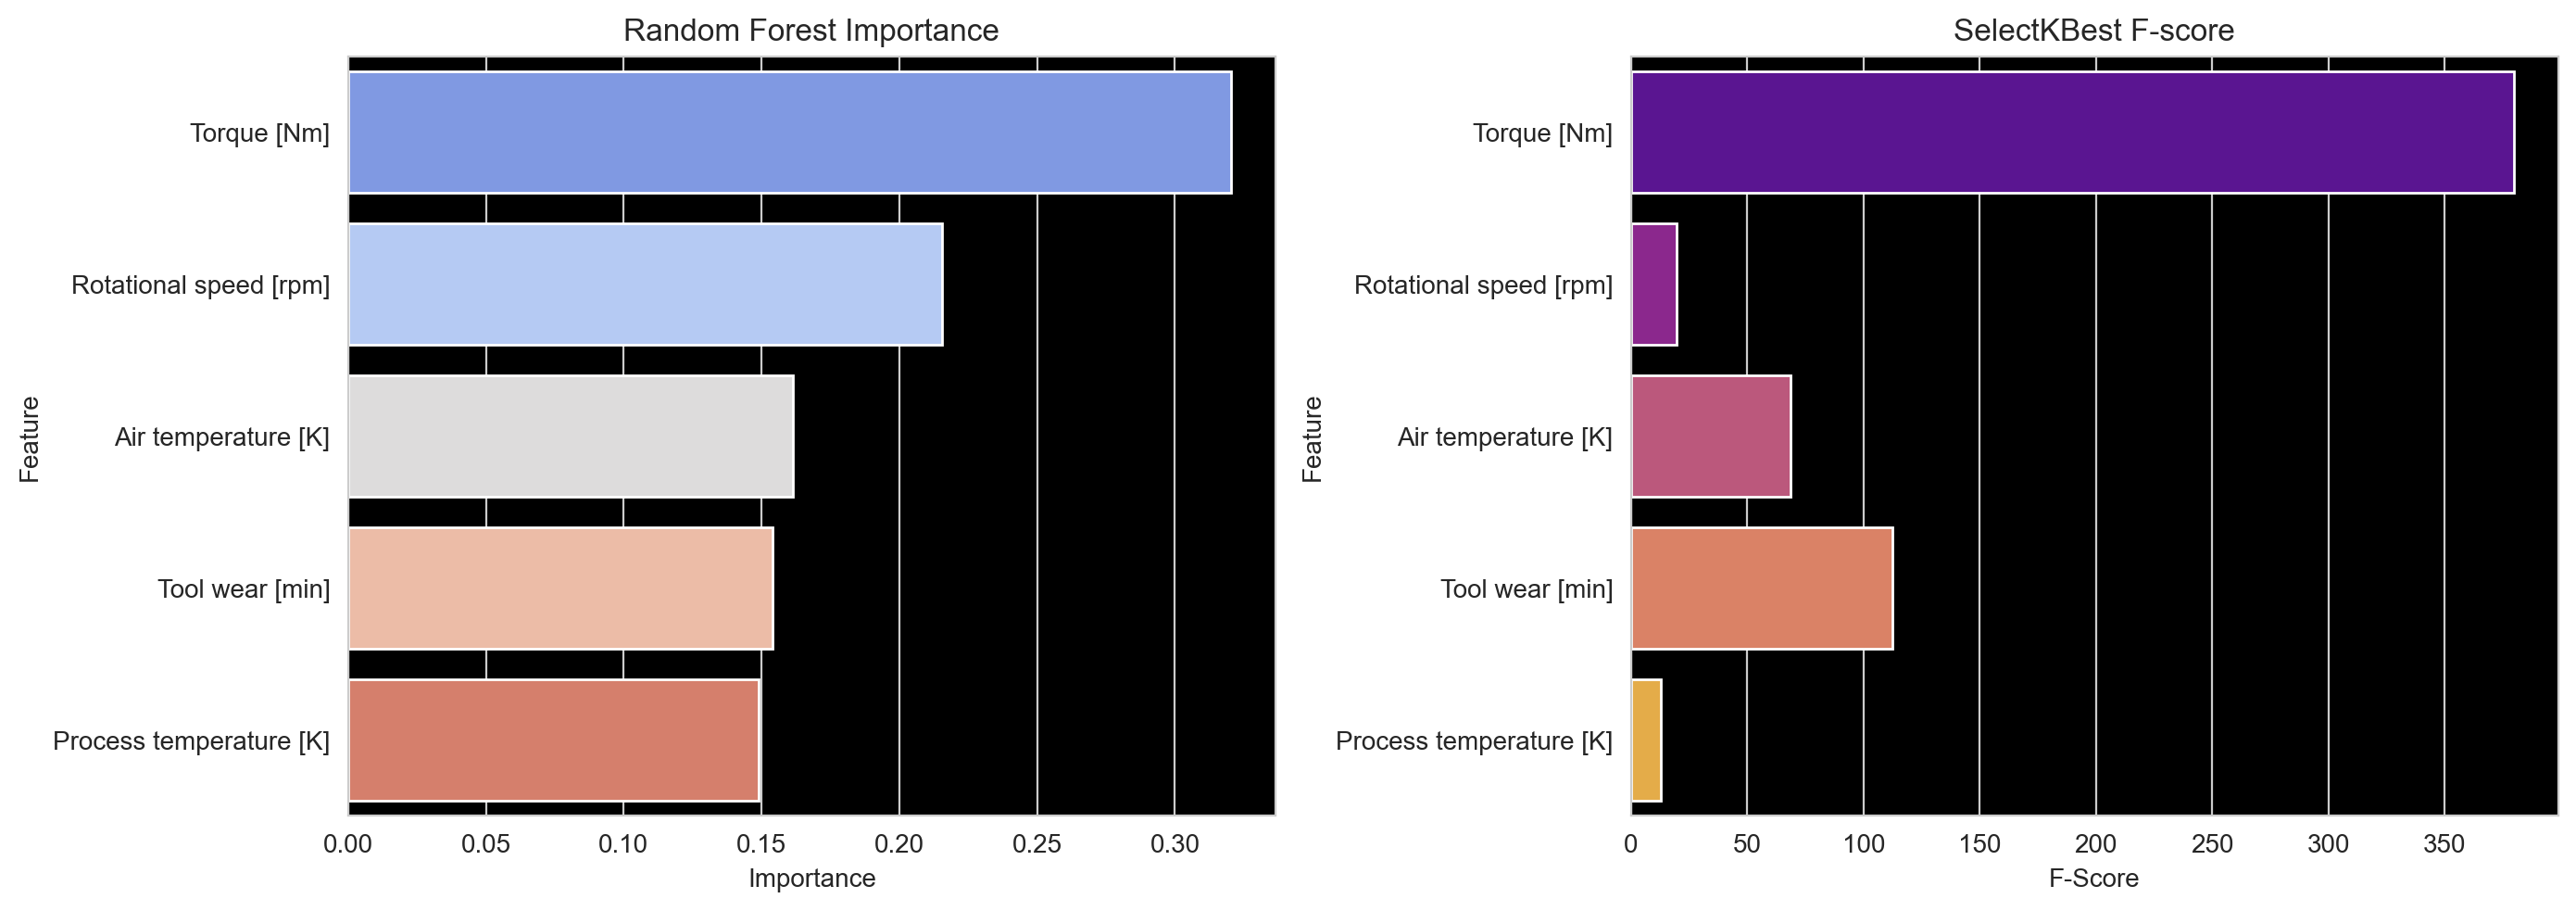

In [27]:
combined_df = feat_importance_df.merge(selectkbest_df, on='Feature')

# Dual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=combined_df, x='Importance', y='Feature', ax=axes[0], palette='coolwarm')
axes[0].set_title('Random Forest Importance')

sns.barplot(data=combined_df, x='F-Score', y='Feature', ax=axes[1], palette='plasma')
axes[1].set_title('SelectKBest F-score')

plt.tight_layout()
plt.show()

# We will be keeping all the five features because our goal is accuracy & explainability and also 
- ## RandomForest & XGBoost handle irrelevant features well by assigning low importance.
- ## Logistic Regression may need feature selection, but we will check its performance first. 

# Models Training 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix ,ConfusionMatrixDisplay,matthews_corrcoef

In [29]:
# Splitting features and target
X = df.drop(columns=['Machine failure'])  # Features
y = df['Machine failure']  # Target

## Oversampling Because data is highly imbalanced 

In [30]:
from imblearn.over_sampling import RandomOverSampler
oversamp = RandomOverSampler(random_state=0)

In [31]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [32]:
# Normalizing features
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','time to train','time to predict','total time'])

# Logistic Classification 

In [34]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
model = LogisticRegression().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 174 ms, sys: 4.33 ms, total: 178 ms
Wall time: 30 ms


## Evaluation for Logistic Classifier 

In [35]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 96.60%
Recall: 96.60%
Precision: 93.32%
F1-Score: 94.93%
MCC: 0.00%
ROC AUC score: 88.29%
time to train: 0.03 s
time to predict: 0.00 s
total: 0.03 s


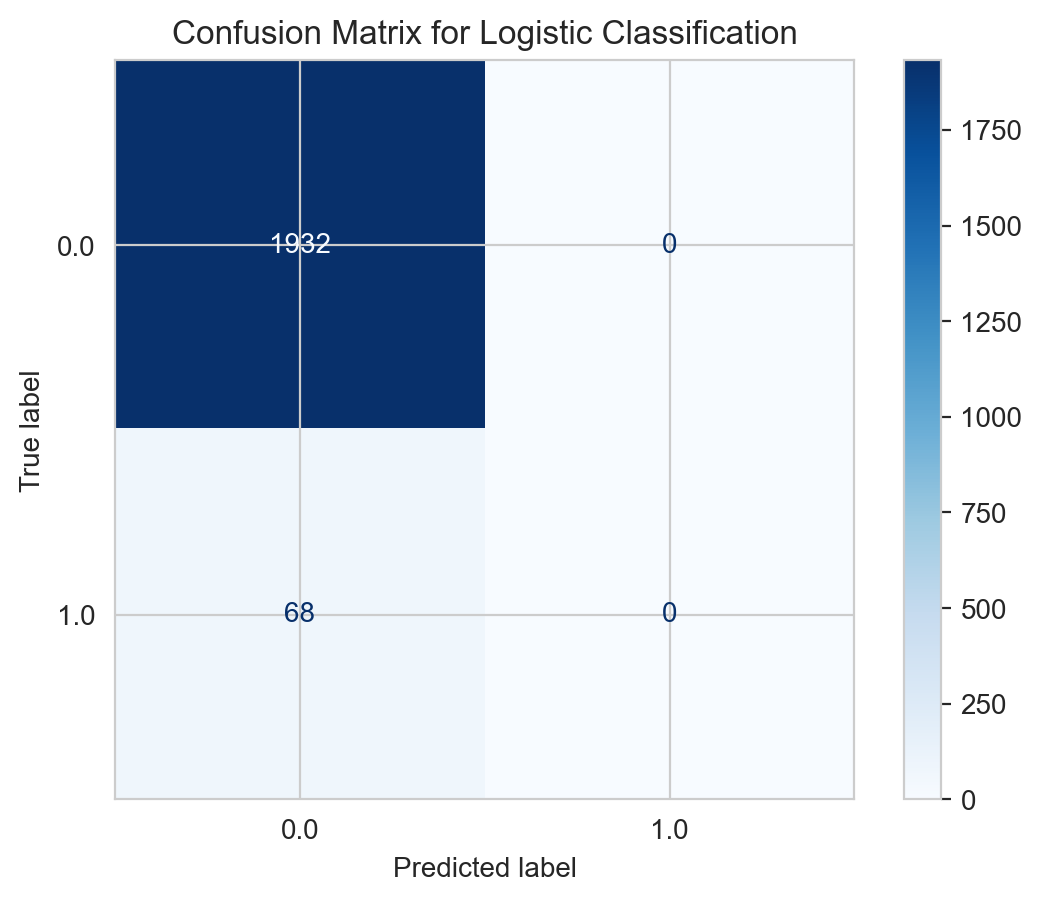

In [36]:
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Classification")
plt.show()

# Random Forest

In [37]:
%%time

start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 973 ms, sys: 408 ms, total: 1.38 s
Wall time: 224 ms


## Evaluation for Random Forest 

In [38]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.55%
Recall: 98.55%
Precision: 98.46%
F1-Score: 98.44%
MCC: 75.55%
ROC AUC score: 95.43%
time to train: 0.21 s
time to predict: 0.01 s
total: 0.22 s


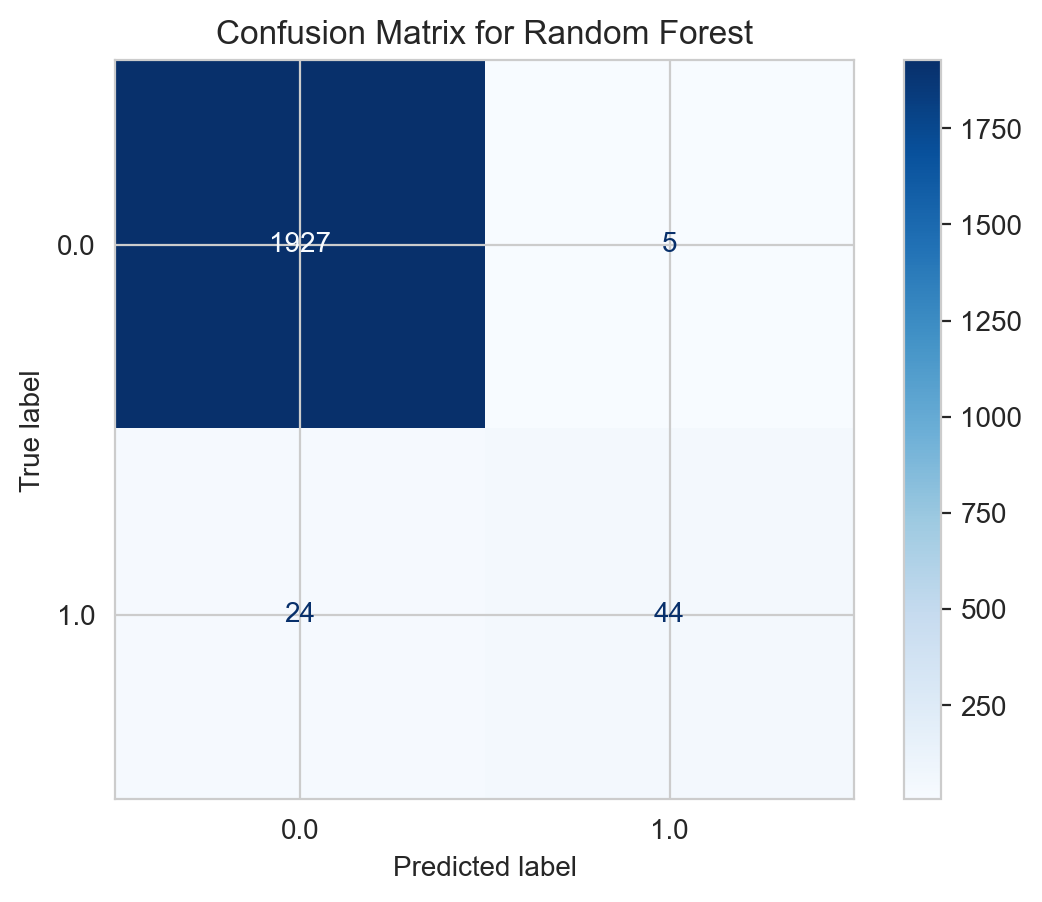

In [39]:
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()

# XGBoost Classifier 

In [40]:
%%time

start = time.time()
model = XGBClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 624 ms, sys: 173 ms, total: 797 ms
Wall time: 126 ms


## Evaluation for XGBoost Classifier 

In [41]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['XGBoost Classifier'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.60%
Recall: 98.60%
Precision: 98.52%
F1-Score: 98.50%
MCC: 76.52%
ROC AUC score: 97.56%
time to train: 0.12 s
time to predict: 0.00 s
total: 0.13 s


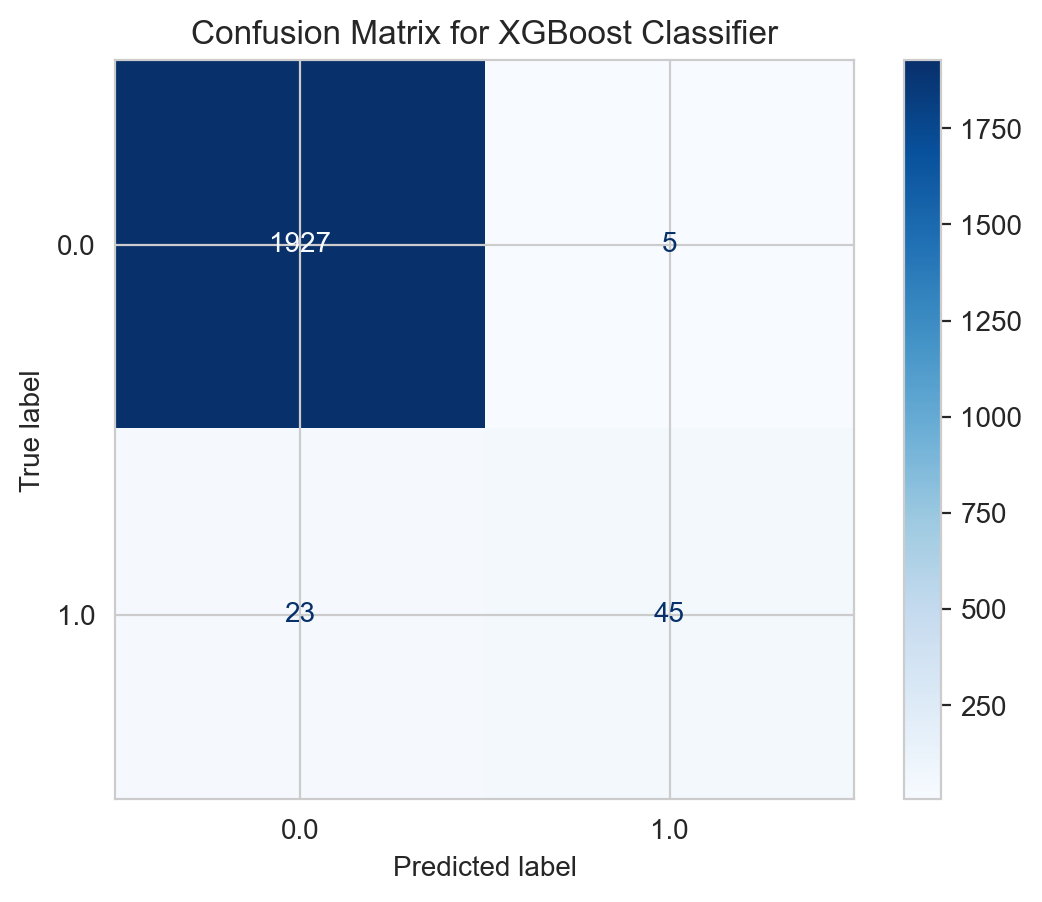

In [42]:
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

# Evaluating all the Models 

In [43]:
model_performance = model_performance.fillna(0.90)
format_dict = {
    'Accuracy': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1-Score': '{:.2%}',
    'MCC score': '{:.2%}',
    'time to train': '{:.1f}',
    'time to predict': '{:.1f}',
    'total time': '{:.1f}'
}
styled_df = (
    model_performance
    .style
    .background_gradient(cmap='Blues')
    .format(format_dict)
)
from IPython.display import display
display(styled_df) 

In [44]:
# !pip install lime shap

## Implementing Explainable AI 

 # 1. LIME 

In [47]:
import lime
import lime.lime_tabular
import numpy as np

# Define your actual feature names manually
feature_names = ['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']  

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Not Failure', 'Failure'],
    mode='classification'
)

# Explain a single instance
i = 0
exp = explainer.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict_proba
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)

# 2. SHAP 

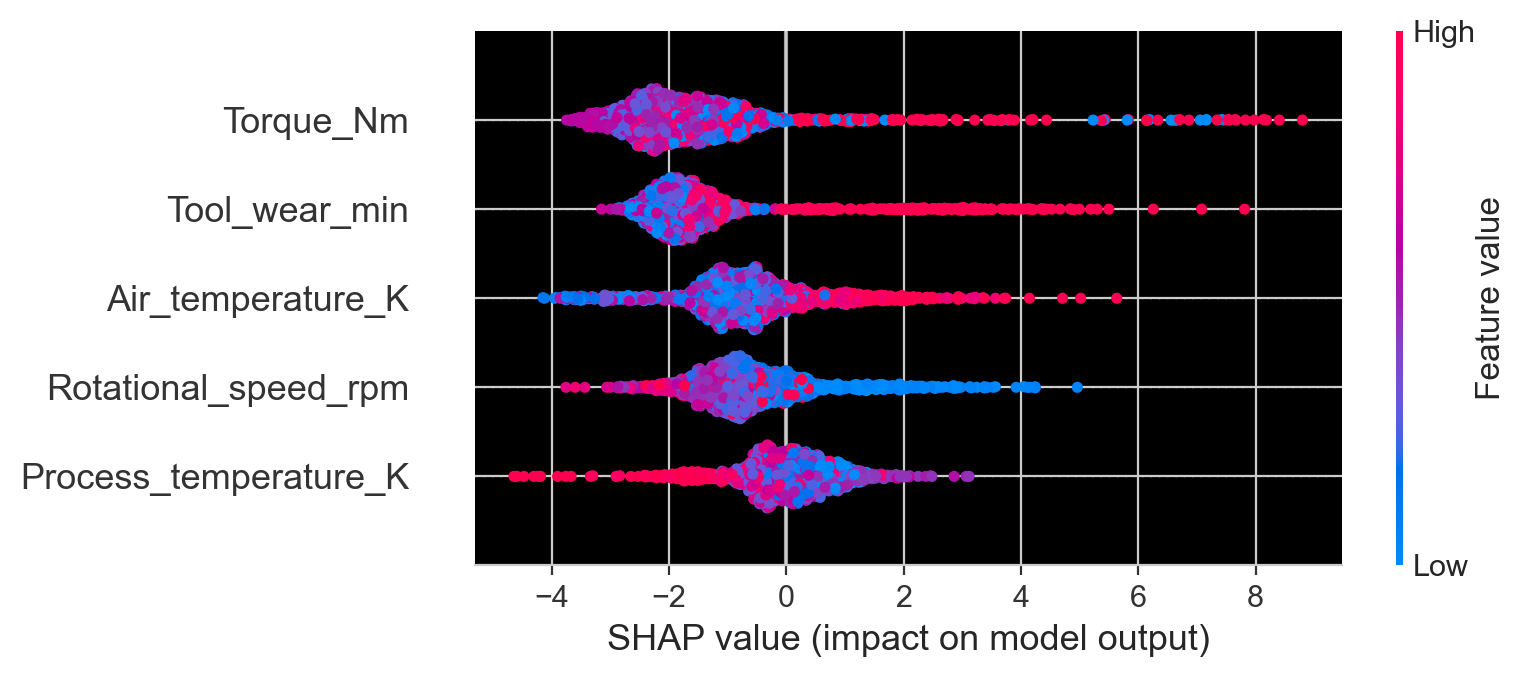

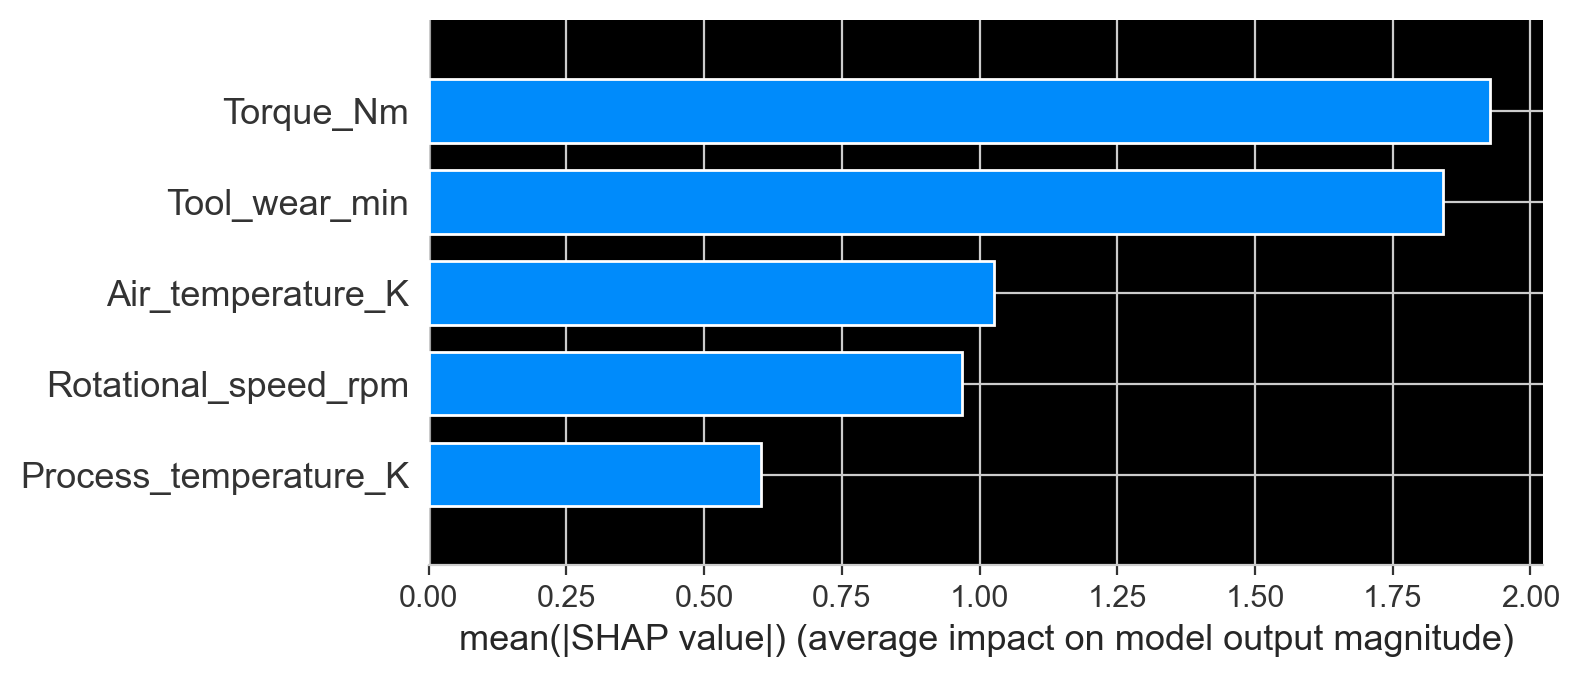

In [48]:
import shap
import matplotlib.pyplot as plt

# Replace special characters in feature names
original_feature_names = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                          'Torque [Nm]', 'Tool wear [min]']

# Cleaned names for XGBoost
clean_feature_names = [name.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') 
                       for name in original_feature_names]

# Recreating DataFrames with cleaned column names
X_train_df = pd.DataFrame(X_train, columns=clean_feature_names)
X_test_df = pd.DataFrame(X_test, columns=clean_feature_names)

# SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_df)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_df, feature_names=clean_feature_names)

# Bar plot (global feature importance)
shap.summary_plot(shap_values, X_test_df, feature_names=clean_feature_names, plot_type="bar")
